In [1]:
#Note - run cells in the below order (and do not re-run them individually)
#     - place csv files in the same folder as the jupyter notebook  

import csv #importing required libraries
from scipy import fft, arange, signal
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import heapq




with open('clean_monthly_data.csv', newline='') as csvfile: #import monthly data as nested dictionary
    
    APMC = csv.reader(csvfile)
    
    APMC_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int)))))))
    
    
    APMC_district_name_product = set() #set containing the combination of districts, names and commodities present in dataset

    
    i=0
    for row in APMC:
        if i > 0: #do not import first row (they are the names of the columns)
            a=[]
            for k in range(4,8):
            
                a.append(int(row[k])) #import the [arrivals_in_qtl, min_price, max_price, modal_price] as a feature vector
          
            #defining set elements
            APMC_district_name_product.add((row[9].lower(),row[0].lower(),row[1].lower()))
            
            #defining dictionary elements
            APMC_data[row[10].lower()][row[9].lower()][row[0].lower()][row[1].lower()][int(row[2])][int(row[3])] = a

                
        i+=1
        



In [2]:
#Seasonality Type Detection Algorithm

#defining nested dictionary to store the trend after deseasonalising the raw data
APMC_trend_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int)))))))

#defining nested dictionary to store the seasonality after deseasonalising the raw data
APMC_seasonal_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int)))))))

#defining nested dictionary to store the residues after deseasonalising the raw data
APMC_residual_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int)))))))

#defining nested dictionary to store the seasonality type of the time series (0: not enough data, 1: additive, 2:multiplicative)
seasonality_type = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int)))))

#dictionary relating values in the seasonality type dictionary to strings describing their meaning
num_to_type = {0: 'not enough data', 1:'additive', 2:'multiplicative'}


for dist_name_prod in APMC_district_name_product:
    
    #empty arrays to store the arrivals_in_qtl, min_price, max_price and modal_price data for each commodity over time (in that order)
    x1=[]
    x2=[]
    x3=[]
    x4=[]
    
    #years for which we have information about the specific commodity
    years = list(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]].keys())  
    
    
    for year in sorted(years): #iterate over these years
        
        #months for which we have information about the specific commodity
        months = list(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year].keys())
        
    
        for month in sorted(months): #iterate over these months
            
            #append the data to the lists
            x1.append(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0])
            x2.append(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1])
            x3.append(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2])
            x4.append(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3])
 
    
    #if we have enough data to detect a seasonality
    if len(x1)>3:
    
        fs=1 #sampling rate = 1 sample/month
        
        
        #Compute the power spectral density of the time series to find the most prominent periodicity in the time series.
        #Knowing this will be useful to compute the moving average of the time series to extract the trend
        f1, Pxx1 = signal.periodogram(x1, fs = fs, window='hanning', scaling='spectrum')
        f2, Pxx2 = signal.periodogram(x2, fs = fs, window='hanning', scaling='spectrum')
        f3, Pxx3 = signal.periodogram(x3, fs = fs, window='hanning', scaling='spectrum')
        f4, Pxx4 = signal.periodogram(x4, fs = fs, window='hanning', scaling='spectrum')

        
        
        #only set the period if the frequency at which the power of the transform is greatest,is larger than 0.07 (i.e. Tmax < 1/0.07 = 14)
        #because otherwise there is not enough time series data to observe several periods.
        
        if f1[np.argmax(Pxx1)] > 0.07:
            
            #most prominent period in arrivals_in_qtl for specific commodity
            period1 = int(1/f1[np.argmax(Pxx1)])
        
        #if the corresponding period is too large find the next largest peak in the power spectral density until the period 
        # is smaller than 14.
        else:
            
            
            index_1 = np.argmax(Pxx1)
            i=1
            
            while f1[index_1] < 0.07:
                
                index_1 = heapq.nlargest(i+1, range(len(Pxx1)), key=Pxx1.__getitem__)
                index_1 = index_1[i]
                i+=1
            
            
            period1 = int(1/f1[index_1])
            
            
                
        #do the same for min_price data
            
        if f2[np.argmax(Pxx2)] > 0.07:
            
            period2 = int(1/f2[np.argmax(Pxx2)])
            
        else:
            
            index_2 = np.argmax(Pxx2)
            i=1
                
            while f2[index_2] < 0.07:
                
                index_2 = heapq.nlargest(i+1, range(len(Pxx2)), key=Pxx2.__getitem__)
                index_2 = index_2[i]
                i+=1
            
            
            period2 = int(1/f2[index_2])
                
          
        #do the same for max_price data
        
        if f3[np.argmax(Pxx3)] > 0.07:
            
            period3 = int(1/f3[np.argmax(Pxx3)])
            
        else:
            
            index_3 = np.argmax(Pxx3)
            i=1
         
            while f3[index_3] < 0.07:
                
                index_3 = heapq.nlargest(i+1, range(len(Pxx3)), key=Pxx3.__getitem__)
                index_3 = index_3[i]
                i+=1
            
            
            period3 = int(1/f3[index_3])
                
        
        #do the same for modal_price data
        
        if f4[np.argmax(Pxx4)] > 0.07:
            
            period4 = int(1/f4[np.argmax(Pxx4)])
            
        else:
            
            index_4 = np.argmax(Pxx4)
            i=1
            
            while f4[index_4] < 0.07:
                
                index_4 = heapq.nlargest(i+1, range(len(Pxx4)), key=Pxx4.__getitem__)
                index_4 = index_4[i]
                i+=1
            
            
            period4 = int(1/f4[index_4])
                

        
        #compute the moving average using the calculated period for all data (arrivals_in_qtl, min_price, max_price, modal_price)
        
        moving_av1=np.convolve(x1, np.ones((period1,))/period1, mode='same')
        moving_av2=np.convolve(x2, np.ones((period2,))/period2, mode='same')
        moving_av3=np.convolve(x3, np.ones((period3,))/period3, mode='same')
        moving_av4=np.convolve(x4, np.ones((period4,))/period4, mode='same')
        
        
        #assuming the seasonality type is additive, detrend the data by subtracting the moving average (i.e. the trend)
        detrended_1_additive = x1 - moving_av1
        detrended_2_additive = x2 - moving_av2
        detrended_3_additive = x3 - moving_av3
        detrended_4_additive = x4 - moving_av4
        
        #assuming the seasonality type is multiplicative, detrend the data by dividing by the moving average (i.e. the trend)
        detrended_1_multiplicative = np.divide(np.array(x1), moving_av1)
        detrended_2_multiplicative = np.divide(np.array(x2), moving_av2)
        detrended_3_multiplicative = np.divide(np.array(x3), moving_av3)
        detrended_4_multiplicative = np.divide(np.array(x4), moving_av4)
        
        #define empty arrays to store the seasonality data for the additive scenario
        seasonality_1_additive = [0] * len(detrended_1_additive)
        seasonality_2_additive = [0] * len(detrended_2_additive)
        seasonality_3_additive = [0] * len(detrended_3_additive)
        seasonality_4_additive = [0] * len(detrended_4_additive)
        
        #define empty arrays to store the seasonality data for the multiplicative scenario
        seasonality_1_multiplicative = [0] * len(detrended_1_multiplicative)
        seasonality_2_multiplicative = [0] * len(detrended_2_multiplicative)
        seasonality_3_multiplicative = [0] * len(detrended_3_multiplicative)
        seasonality_4_multiplicative = [0] * len(detrended_4_multiplicative)
        
        
        #to compute the seasonality, calculate the average of the datapoints in the detrended time series
        #at intervals corresponding to multiples of the period
        
        #for additive scenario
        
        #for arrivals_in_qtl
        for i in range(period1):
            
            a=[]
            p=i
            var=0
            while p < len(detrended_1_additive):
            
                a.append(p)
                p+=period1
                
            for k in a:
                
                var += detrended_1_additive[k]
            
            for t in a:
                
                seasonality_1_additive[t] = var/len(a)
                
            
        #for min_price
        for i in range(period2):
            
            a=[]
            p=i
            var=0
            while p < len(detrended_2_additive):
            
                a.append(p)
                p+=period2
                
            for k in a:
                
                var += detrended_2_additive[k]
            
            for t in a:
                
                seasonality_2_additive[t] = var/len(a)
         
        #for max_price
        for i in range(period3):
            
            a=[]
            p=i
            var=0
            while p < len(detrended_3_additive):
            
                a.append(p)
                p+=period3
                
            for k in a:
                
                var += detrended_3_additive[k]
            
            for t in a:
                
                seasonality_3_additive[t] = var/len(a)
        
        #for modal_price
        for i in range(period4):
        
            a=[]
            p=i
            var=0
            while p < len(detrended_4_additive):
            
                a.append(p)
                p+=period4
                
            for k in a:
                
                var += detrended_4_additive[k]
            
            for t in a:
                
                seasonality_4_additive[t] = var/len(a)
                
        
        #same thing for multiplicative scenario
        
        for i in range(period1):
            
            a=[]
            p=i
            var=0
            while p < len(detrended_1_multiplicative):
            
                a.append(p)
                p+=period1
                
            for k in a:
                
                var += detrended_1_multiplicative[k]
            
            for t in a:
                
                seasonality_1_multiplicative[t] = var/len(a)
                
            
            
        for i in range(period2):
            
            a=[]
            p=i
            var=0
            while p < len(detrended_2_multiplicative):
            
                a.append(p)
                p+=period2
                
            for k in a:
                
                var += detrended_2_multiplicative[k]
            
            for t in a:
                
                seasonality_2_multiplicative[t] = var/len(a)
         
        for i in range(period3):
            
            a=[]
            p=i
            var=0
            while p < len(detrended_3_multiplicative):
            
                a.append(p)
                p+=period3
                
            for k in a:
                
                var += detrended_3_multiplicative[k]
            
            for t in a:
                
                seasonality_3_multiplicative[t] = var/len(a)
        
        for i in range(period4):
        
            a=[]
            p=i
            var=0
            while p < len(detrended_4_multiplicative):
            
                a.append(p)
                p+=period4
                
            for k in a:
                
                var += detrended_4_multiplicative[k]
            
            for t in a:
                
                seasonality_4_multiplicative[t] = var/len(a)
                
        
        #compute the residual for all data by subtracting the seasonality from the detrended data
        
        #for additive scenario
        
        residual_1_additive = detrended_1_additive - seasonality_1_additive
        residual_2_additive = detrended_2_additive - seasonality_2_additive
        residual_3_additive = detrended_3_additive - seasonality_3_additive
        residual_4_additive = detrended_4_additive - seasonality_4_additive
        
        #for multiplicative scenario
        
        residual_1_multiplicative = np.divide(np.array(detrended_1_multiplicative), np.array(seasonality_1_multiplicative))
        residual_2_multiplicative = np.divide(np.array(detrended_1_multiplicative), np.array(seasonality_1_multiplicative))
        residual_3_multiplicative = np.divide(np.array(detrended_1_multiplicative), np.array(seasonality_1_multiplicative))
        residual_4_multiplicative = np.divide(np.array(detrended_1_multiplicative), np.array(seasonality_1_multiplicative))
        
        
        #compute the autocorrelation factor (acf) for the residual time series of all data
        #and perform the sum of squares over the acf (ss_acf)
        
        #additive scenario
        
        acf_add_1 = np.correlate(residual_1_additive, residual_1_additive, mode='full')
        acf_add_1 = acf_add_1[len(acf_add_1)//2:]
        ss_acf_add_1 = sum(map(lambda x:x*x,acf_add_1))
        
        acf_add_2 = np.correlate(residual_2_additive, residual_2_additive, mode='full')
        acf_add_2 = acf_add_2[len(acf_add_2)//2:]
        ss_acf_add_2 = sum(map(lambda x:x*x,acf_add_2))
        
        acf_add_3 = np.correlate(residual_3_additive, residual_3_additive, mode='full')
        acf_add_3 = acf_add_3[len(acf_add_3)//2:]
        ss_acf_add_3 = sum(map(lambda x:x*x,acf_add_3))
        
        acf_add_4 = np.correlate(residual_4_additive, residual_4_additive, mode='full')
        acf_add_4 = acf_add_3[len(acf_add_4)//2:]
        ss_acf_add_4 = sum(map(lambda x:x*x,acf_add_4))
        
        #multiplicative scenario
        
        acf_mult_1 = np.correlate(residual_1_multiplicative, residual_1_multiplicative, mode='full')
        acf_mult_1 = acf_mult_1[len(acf_mult_1)//2:]
        ss_acf_mult_1 = sum(map(lambda x:x*x,acf_mult_1))
        
        acf_mult_2 = np.correlate(residual_2_multiplicative, residual_2_multiplicative, mode='full')
        acf_mult_2 = acf_mult_2[len(acf_mult_2)//2:]
        ss_acf_mult_2 = sum(map(lambda x:x*x,acf_mult_2))
        
        acf_mult_3 = np.correlate(residual_3_multiplicative, residual_3_multiplicative, mode='full')
        acf_mult_3 = acf_mult_1[len(acf_mult_3)//2:]
        ss_acf_mult_3 = sum(map(lambda x:x*x,acf_mult_3))
        
        acf_mult_4 = np.correlate(residual_4_multiplicative, residual_4_multiplicative, mode='full')
        acf_mult_4 = acf_mult_4[len(acf_mult_4)//2:]
        ss_acf_mult_4 = sum(map(lambda x:x*x,acf_mult_4))
        
        
        #classify each data type (i.e. arrivals_in_qtl, min_price, max_price, modal_price)
        #as either having an additive or multiplicative seasonality according to whether 
        #the sum of squares of the residual is greater for the additive or multiplicative scenario
        
        #for arrivals_in_qtl
        
        # if the additive ss_acf is smaller than the multiplicative ss_acf then the time series is additive
        if ss_acf_add_1 != 0 and ss_acf_add_1 < ss_acf_mult_1:
            
            #populate the seasonality type dictionary with the appropriate parameter
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][0] = 1 #additive
            
            
            
        # if the additive ss_acf is larger than the multiplicative ss_acf then the time series is multiplicative
        elif ss_acf_add_1 != 0 and ss_acf_add_1 > ss_acf_mult_1:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][0] = 2  #multiplicative
           
        
        #if the period was too large and we could not compute the moving averages then we leave the time series as it is
        #and state that there was not enough data to tell the seasonality type.
        
        else:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][0] = 0 #not enough data
            
        
        #same for min_price
        
        if ss_acf_add_2 != 0 and ss_acf_add_2 < ss_acf_mult_2:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][1] = 1
            
            #additive
            
        elif ss_acf_add_2 != 0 and ss_acf_add_2 > ss_acf_mult_2:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][1] = 2
            #multiplicative
            
        else:
        
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][1] = 0
            #not enough data
            
        #same for max_price
        
        if ss_acf_add_3 != 0 and ss_acf_add_3 < ss_acf_mult_3:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][2] = 1
            
            #additive
            
        elif ss_acf_add_3 != 0 and ss_acf_add_3 > ss_acf_mult_3:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][2] = 2
            #multiplicative
            
        else:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][2] = 0
            #not enough data
            
        #same for modal_price
        
        if ss_acf_add_4 != 0 and ss_acf_add_4 < ss_acf_mult_4:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][3] = 1
            
            #additive
            
        elif ss_acf_add_4 != 0 and ss_acf_add_4 > ss_acf_mult_4:
            
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][3] = 2
            #multiplicative
            
        else:
           
            seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][3] = 0
            #not enough data
        
    
    #now that we know the seasonality type of the time series we can store the correct deseasonalised data
    
    
    #iterate over years and months as before
    
    years = list(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]].keys())
        
    g=0
    for year in sorted(years):
            
        months = list(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year].keys())
    
        for month in sorted(months):
                
            #according to the seasonality type, assign the appropriate time series to the dictionary entry
            
            #for arrivals_in_qtl
            
            #if it is not zero then assign the trend, seasonality and residual time series to the appropriate keys in the dictionary
            if seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][0] != 0:
                
                #trend is the same for both additive and multiplicative models
                APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0] = moving_av1[g]

                #if additive, assign the additive seasonal and residual time series
                if seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][0] == 1:

                    #populate dictionaries
                    APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0] = seasonality_1_additive[g]
                    APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0] = residual_1_additive[g]

                elif seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][0] == 2:

                    APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0] = seasonality_1_multiplicative[g]
                    APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0] = residual_1_multiplicative[g]
            
            #if it is 0 then the trend, seasonal and residual data have no menaing and hence we assign the raw data to the dictionary
            else:
                    
                APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0] = x1[g]
                APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0] = x1[g]
                APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0] = x1[g]
                    
            
            #same for min_price
            if seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][1] != 0:
                
            
                APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1] = moving_av2[g]


                if seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][1] == 1:


                    APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1] = seasonality_2_additive[g]
                    APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1] = residual_2_additive[g]

                elif seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][1] == 2:

                    APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1] = seasonality_2_multiplicative[g]
                    APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1] = residual_2_multiplicative[g]
            else:
                    
                APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1] = x2[g]
                APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1] = x2[g]
                APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1] = x2[g] 
                    
                    
            #same for max_price
            if seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][2] != 0:
                
            
                APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2] = moving_av3[g]


                if seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][2] == 1:


                    APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2] = seasonality_3_additive[g]
                    APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2] = residual_3_additive[g]

                elif seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][2] == 2:

                    APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2] = seasonality_3_multiplicative[g]
                    APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2] = residual_3_multiplicative[g]
                    
                    
            else:
                    
                APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2] = x3[g]
                APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2] = x3[g]
                APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2] = x3[g] 
             
            #same for modal_price
            if seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][3] != 0:
                
            
                APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3] = moving_av4[g]


                if seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][3] == 1:


                    APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3] = seasonality_4_additive[g]
                    APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3] = residual_4_additive[g]

                elif seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][3] == 2:

                    APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3] = seasonality_4_multiplicative[g]
                    APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3] = residual_4_multiplicative[g]
                    
            else:
                    
                APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3] = x4[g]
                APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3] = x4[g]
                APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3] = x4[g] 
                   
            g+=1
            
                


In [4]:
#write the seasonality type data to a csv file 

with open('seasonality_type.csv', mode='w', newline='') as clean_data:
    
    clean_data_writer = csv.writer(clean_data, delimiter=',', quotechar='"', quoting=csv.QUOTE_NONE)
    
    #first row contains titles
    clean_data_writer.writerow(['APMC', 'Commodity', 'arrivals_in_qtl Seasonality Type','min_price Seasonality Type','max_price Seasonality Type','modal_price Seasonality Type', 'district_name', 'state_name'])
    
    
    
    for dist_name_prod in APMC_district_name_product:
        
        #populate the rest of the csv file with the type of seasonality for each commodity's data type (arrivals_in_qtl, min_price, max_price, modal_price)
        clean_data_writer.writerow([dist_name_prod[1], dist_name_prod[2], num_to_type[seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][0]], num_to_type[seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][1]] ,num_to_type[seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][2]], num_to_type[seasonality_type['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][3]], dist_name_prod[0], 'maharashtra'])
        
        

        

In [3]:
# create a new csv file with the deseasonalised data for each commodity at specific timepoints

with open('deseasonalised_data.csv', mode='w', newline='') as clean_data:
    clean_data_writer = csv.writer(clean_data, delimiter=',', quotechar='"', quoting=csv.QUOTE_NONE)
    
    #first row contains titles
    clean_data_writer.writerow(['APMC', 'Commodity','year','month', 'arrivals_in_qtl raw','arrivals_in_qtl trend','arrivals_in_qtl seasonal','arrivals_in_qtl residual','min_price raw','min_price trend','min_price seasonal','min_price residual', 'max_price raw','max_price trend','max_price seasonal','max_price residual', 'modal_price raw','modal_price trend','modal_price seasonal','modal_price residual','district_name', 'state_name'])
    
    
    
    #iterate over commodities, years and months as usual
    
    for dist_name_prod in APMC_district_name_product:
        
        years = list(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]].keys())
        
        for year in sorted(years):
            
            months = list(APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year].keys())
        
            for month in sorted(months):
        
                #populate the csv file with the raw and deseasonlised data organised as shown in the title row
                clean_data_writer.writerow([dist_name_prod[1], dist_name_prod[2],year,month, APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0], APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0], APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0], APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][0], APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1], APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1], APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1], APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][1], APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2], APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2], APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2], APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][2], APMC_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3], APMC_trend_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3], APMC_seasonal_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3], APMC_residual_data['maharashtra'][dist_name_prod[0]][dist_name_prod[1]][dist_name_prod[2]][year][month][3], dist_name_prod[0], 'maharashtra'])   
        

Text(0,0.5,'Arrivals in qtl')

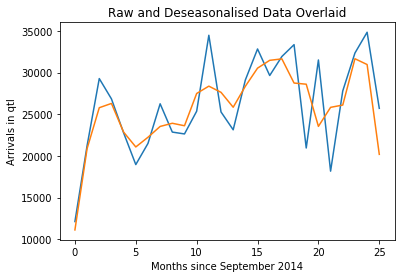

In [4]:
#verifying the success of deseasonalisation by plotting data before and after deseasonalising
#e.g. Spilt Gerrn Gram in Mumbai
x1=[]
x2=[]
x3=[]
x4=[]

y1=[]
y2=[]
y3=[]
y4=[]
    

years = list(APMC_data['maharashtra']['mumbai']['mumbai']['spilt gerrn gram'].keys())
    
for year in sorted(years):
    
    months = list(APMC_data['maharashtra']['mumbai']['mumbai']['spilt gerrn gram'][year].keys())
        
    
    for month in sorted(months):
            
        x1.append(APMC_data['maharashtra']['mumbai']['mumbai']['spilt gerrn gram'][year][month][0])
        y1.append(APMC_trend_data['maharashtra']['mumbai']['mumbai']['spilt gerrn gram'][year][month][0])
 
        
            
plt.plot(x1)
plt.plot(y1)
plt.title('Raw and Deseasonalised Data Overlaid')
plt.xlabel('Months since September 2014')
plt.ylabel('Arrivals in qtl')

